In [1]:
##Churn Challenge

'''
https://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction

https://medium.com/@lucapetriconi/churn-modeling-a-detailed-step-by-step-guide-in-python-1e96d51c7523
'''

# 2.3 Scaling - StandardScaler -> Can't encode too soon OR! have to encode everything but the Churn variable! 
# Create a dataframe that doesn't have churn, then scale, then recombine and see the effect on the scaled variables - DONE!

# 2.4 Feature Selection - SelectKBest -> !! Need to select best features - What are the thresholds for rejecting variables though?

# 4.0 Resolve k_range issues at the end of the notebook - DONE!

# 1.0 for recasting and changing the data etc.  only apply this to the training data set and leave the test alone.  
# Later when testing the model, apply those changes to the test data set as well.

# For categorical data use a percentage par chart instead of matrix chart

# Between step 3 and 4 create a pipeline for the test data as well.

## Why two training/test splits? 

###################################################################

## Look for Q-cut function and apply at the end of the model to quartile the output

## Look into feature selection and tuning the models once created.  Hyperparameter tuning for the random forest model and stopping rules etc of the model to improve performance and explain.  get_pameters() function?  Iterate and see what works best for random forest.




'\nhttps://www.kaggle.com/datasets/ankitverma2010/ecommerce-customer-churn-analysis-and-prediction\n\nhttps://medium.com/@lucapetriconi/churn-modeling-a-detailed-step-by-step-guide-in-python-1e96d51c7523\n'

In [2]:
## Basics 
import numpy as np
import pandas as pd
## Visualization
import matplotlib as plt
import matplotlib.pyplot as plt
import seaborn as sns
## ML
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc, RocCurveDisplay
## Algorithms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
## Open File
import openpyxl
## Remove Warnings
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [3]:
# Path to your Excel file
file_path = 'E Commerce Dataset.xlsx'

# Load the Excel file into a DataFrame
df = pd.read_excel(file_path, engine='openpyxl', sheet_name='E Comm')

In [4]:
# Shape of dataframe
df.shape

(5630, 20)

In [5]:
## Split the data to create a train and test set
train, test = train_test_split(df, test_size=0.25)

In [6]:
# 1. Exploratory Data Analysis

In [7]:
## Looking at data types and correct those wrongly encoded
train.dtypes

CustomerID                       int64
Churn                            int64
Tenure                         float64
PreferredLoginDevice            object
CityTier                         int64
WarehouseToHome                float64
PreferredPaymentMode            object
Gender                          object
HourSpendOnApp                 float64
NumberOfDeviceRegistered         int64
PreferedOrderCat                object
SatisfactionScore                int64
MaritalStatus                   object
NumberOfAddress                  int64
Complain                         int64
OrderAmountHikeFromlastYear    float64
CouponUsed                     float64
OrderCount                     float64
DaySinceLastOrder              float64
CashbackAmount                 float64
dtype: object

In [8]:
def missing_values(data):
    # Initialize a list to collect results
    results = []
    
    for col in data.columns:
        # Get unique values
        unique_values = data[col].unique()
        try:
            unique_values = np.sort(unique_values)
        except Exception:
            pass
        
        # Calculate metrics
        nans = round(pd.isna(data[col]).sum() / data.shape[0] * 100, 1)
        zeros = round((data[col] == 0).sum() / data.shape[0] * 100, 1)
        
        # Append metrics to the results list
        results.append({
            'variable': col,
            'Unique values': len(unique_values),
            'Nan %': nans,
            'zeros %': zeros
        })
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort results by 'Nan %' in descending order
    results_df = results_df.sort_values('Nan %', ascending=False)
    
    return results_df

print(missing_values(train))

                       variable  Unique values  Nan %  zeros %
18            DaySinceLastOrder             23    5.4      9.1
2                        Tenure             36    5.0      9.1
15  OrderAmountHikeFromlastYear             17    4.9      0.0
16                   CouponUsed             17    4.7     18.0
17                   OrderCount             17    4.5      0.0
8                HourSpendOnApp              7    4.5      0.0
5               WarehouseToHome             35    4.4      0.0
0                    CustomerID           4222    0.0      0.0
3          PreferredLoginDevice              3    0.0      0.0
1                         Churn              2    0.0     82.9
6          PreferredPaymentMode              7    0.0      0.0
4                      CityTier              3    0.0      0.0
11            SatisfactionScore              5    0.0      0.0
10             PreferedOrderCat              6    0.0      0.0
9      NumberOfDeviceRegistered              6    0.0  

In [9]:
# Replace missing values with -1 and recast values
train['Tenure'] = train['Tenure'].fillna(-1).astype('Int64')
train['WarehouseToHome'] = train['WarehouseToHome'].fillna(-1).astype('Int64')
train['OrderAmountHikeFromlastYear'] = train['OrderAmountHikeFromlastYear'].fillna(-1).astype('Int64')
train['CouponUsed'] = train['CouponUsed'].fillna(-1).astype('Int64')
train['OrderCount'] = train['OrderCount'].fillna(-1).astype('Int64')
train['DaySinceLastOrder'] = train['DaySinceLastOrder'].fillna(-1).astype('Int64')

#Filling in Nulls but don't need to recast
train['HourSpendOnApp'] = train['HourSpendOnApp'].fillna(-1)
train['DaySinceLastOrder'] = train['DaySinceLastOrder'].fillna(-1)

#PreferedOrderCat is misspelled
train['PreferredOrderCat'] = train['PreferedOrderCat']

#Remove PreferedOrderCat and CustomerID from the dataframe
train = train.drop(columns=['PreferedOrderCat'])
train = train.drop(columns=['CustomerID'])

In [10]:
train.head

<bound method NDFrame.head of       Churn  Tenure PreferredLoginDevice  CityTier  WarehouseToHome  \
47        0      -1             Computer         1                9   
1164      0      11             Computer         2               -1   
3009      0       6         Mobile Phone         3               15   
4705      0       4         Mobile Phone         3               34   
2494      0       0                Phone         1               25   
...     ...     ...                  ...       ...              ...   
3573      0       7         Mobile Phone         1               16   
2         1      -1                Phone         1               30   
1967      0       5                Phone         3               19   
113       0       5                Phone         3               10   
4167      0       4         Mobile Phone         1               31   

     PreferredPaymentMode  Gender  HourSpendOnApp  NumberOfDeviceRegistered  \
47                     CC    Male     

In [11]:
## Looking at data types and correct those wrongly encoded
train.dtypes

Churn                            int64
Tenure                           Int64
PreferredLoginDevice            object
CityTier                         int64
WarehouseToHome                  Int64
PreferredPaymentMode            object
Gender                          object
HourSpendOnApp                 float64
NumberOfDeviceRegistered         int64
SatisfactionScore                int64
MaritalStatus                   object
NumberOfAddress                  int64
Complain                         int64
OrderAmountHikeFromlastYear      Int64
CouponUsed                       Int64
OrderCount                       Int64
DaySinceLastOrder                Int64
CashbackAmount                 float64
PreferredOrderCat               object
dtype: object

In [12]:
train.isnull().sum()

Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
PreferredOrderCat              0
dtype: int64

In [13]:
# Count NaN values for each column
nan_count_per_column = train.isna().sum()
print("NaN values per column:")
print(nan_count_per_column)

NaN values per column:
Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
PreferredOrderCat              0
dtype: int64


In [14]:
# Filter rows where any column has NaN
rows_with_nan = train[train.isna().any(axis=1)]
print("Rows with NaN values:")
print(rows_with_nan)

Rows with NaN values:
Empty DataFrame
Columns: [Churn, Tenure, PreferredLoginDevice, CityTier, WarehouseToHome, PreferredPaymentMode, Gender, HourSpendOnApp, NumberOfDeviceRegistered, SatisfactionScore, MaritalStatus, NumberOfAddress, Complain, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, CashbackAmount, PreferredOrderCat]
Index: []


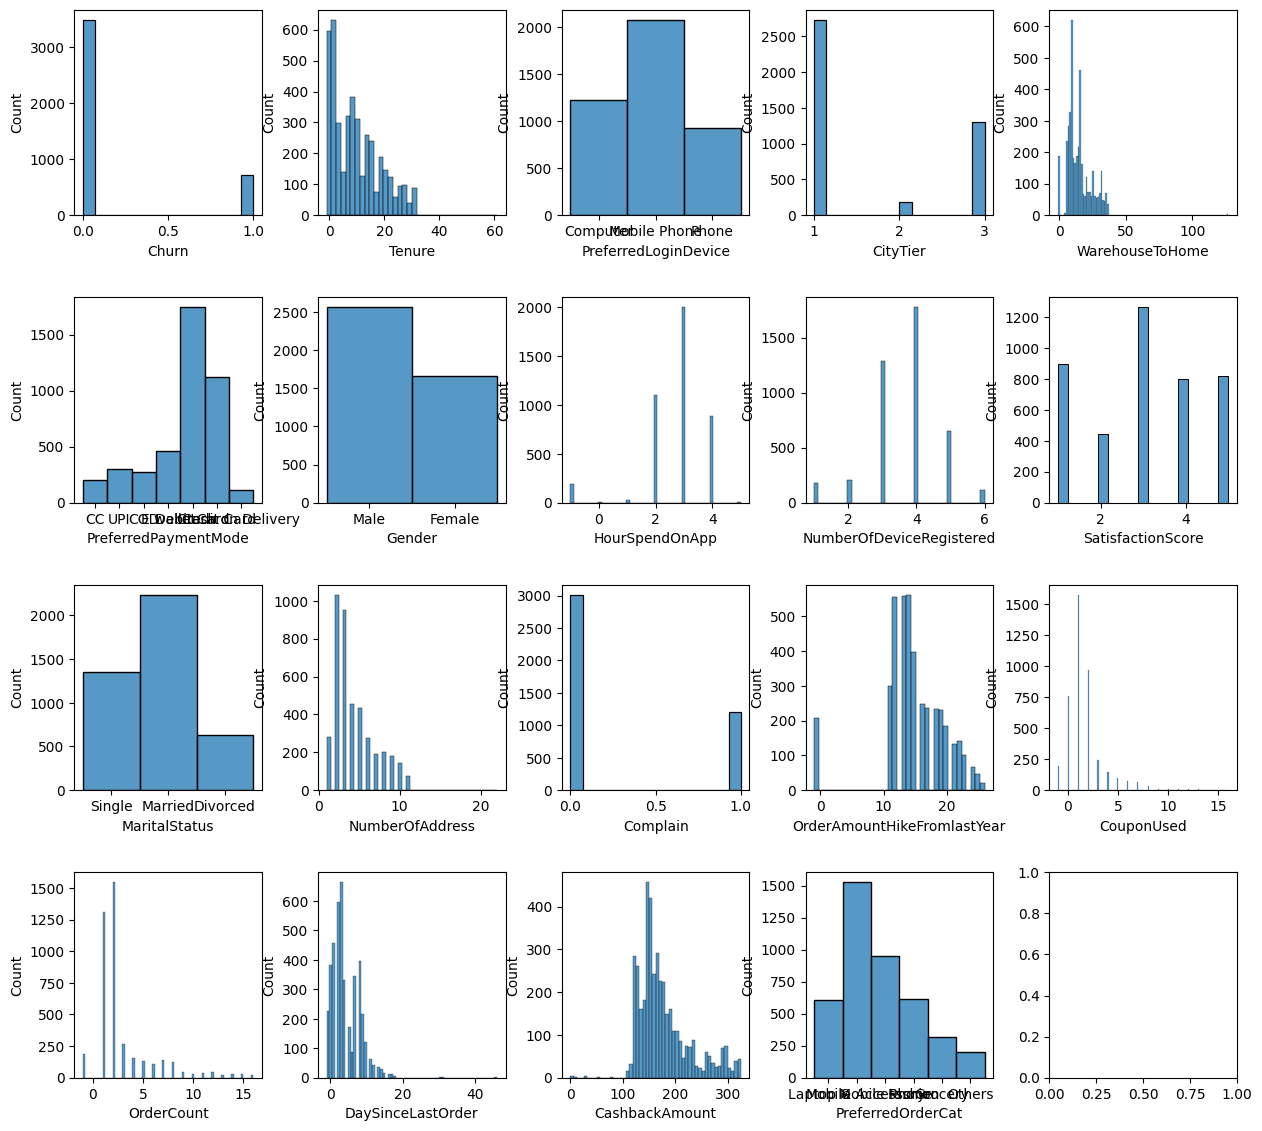

In [15]:
fig, ax = plt.subplots(4, 5, figsize=(15, 12))
plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=0.3, hspace=0.4)
for variable, subplot in zip(train.columns, ax.flatten()):
  sns.histplot(train[variable], ax=subplot)

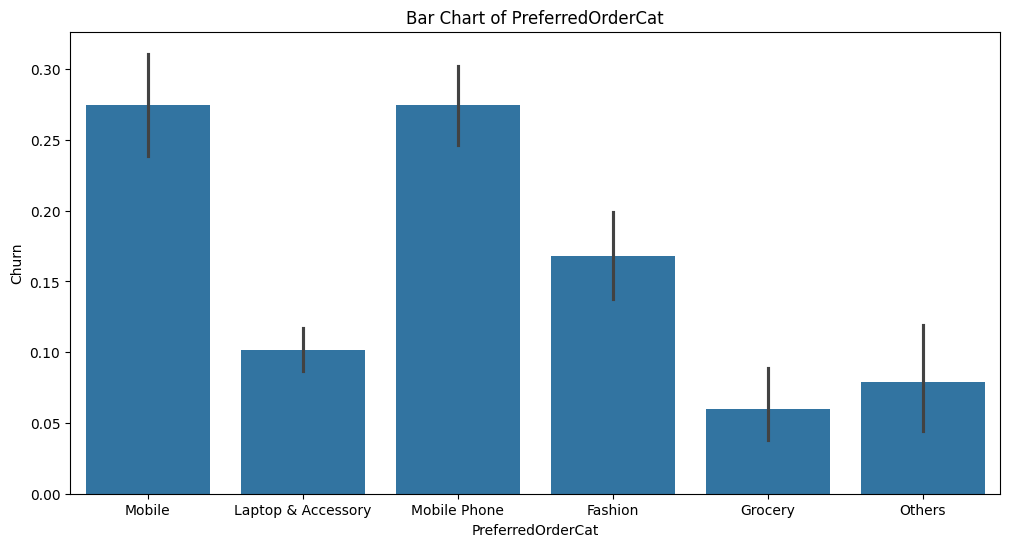

In [16]:
# Adjust figure size
plt.figure(figsize=(12, 6))  # Increase width (12) and height (6)

# Plot Bar Chart of PreferredOrderCat
sns.barplot(data=train, x='PreferredOrderCat', y='Churn')
plt.title('Bar Chart of PreferredOrderCat')
plt.xlabel('PreferredOrderCat')
plt.ylabel('Churn')
plt.show()

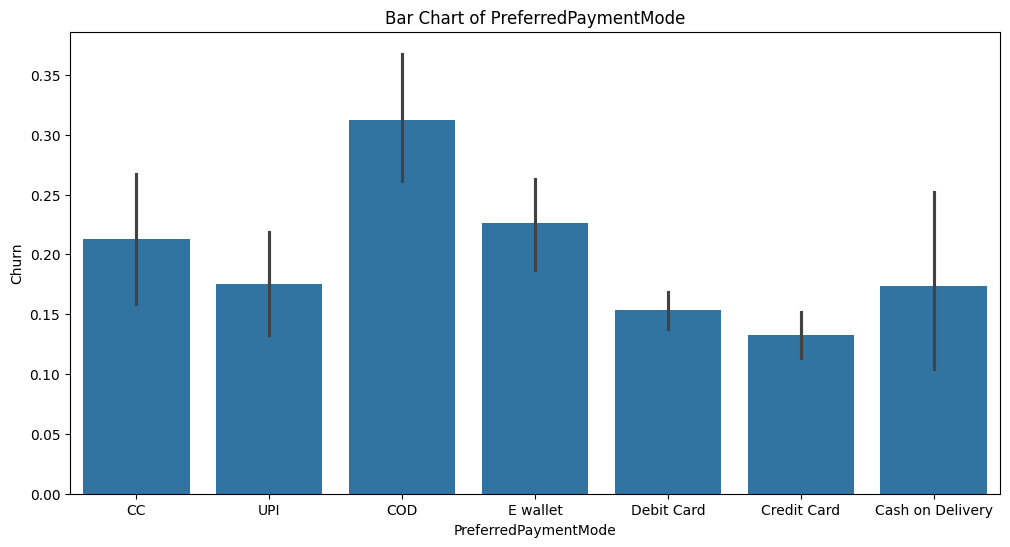

In [17]:
# Adjust figure size
plt.figure(figsize=(12, 6))  # Increase width (12) and height (6)

# Plot Bar Chart of PreferredPaymentMode
sns.barplot(data=train, x='PreferredPaymentMode', y='Churn')
plt.title('Bar Chart of PreferredPaymentMode')
plt.xlabel('PreferredPaymentMode')
plt.ylabel('Churn')
plt.show()

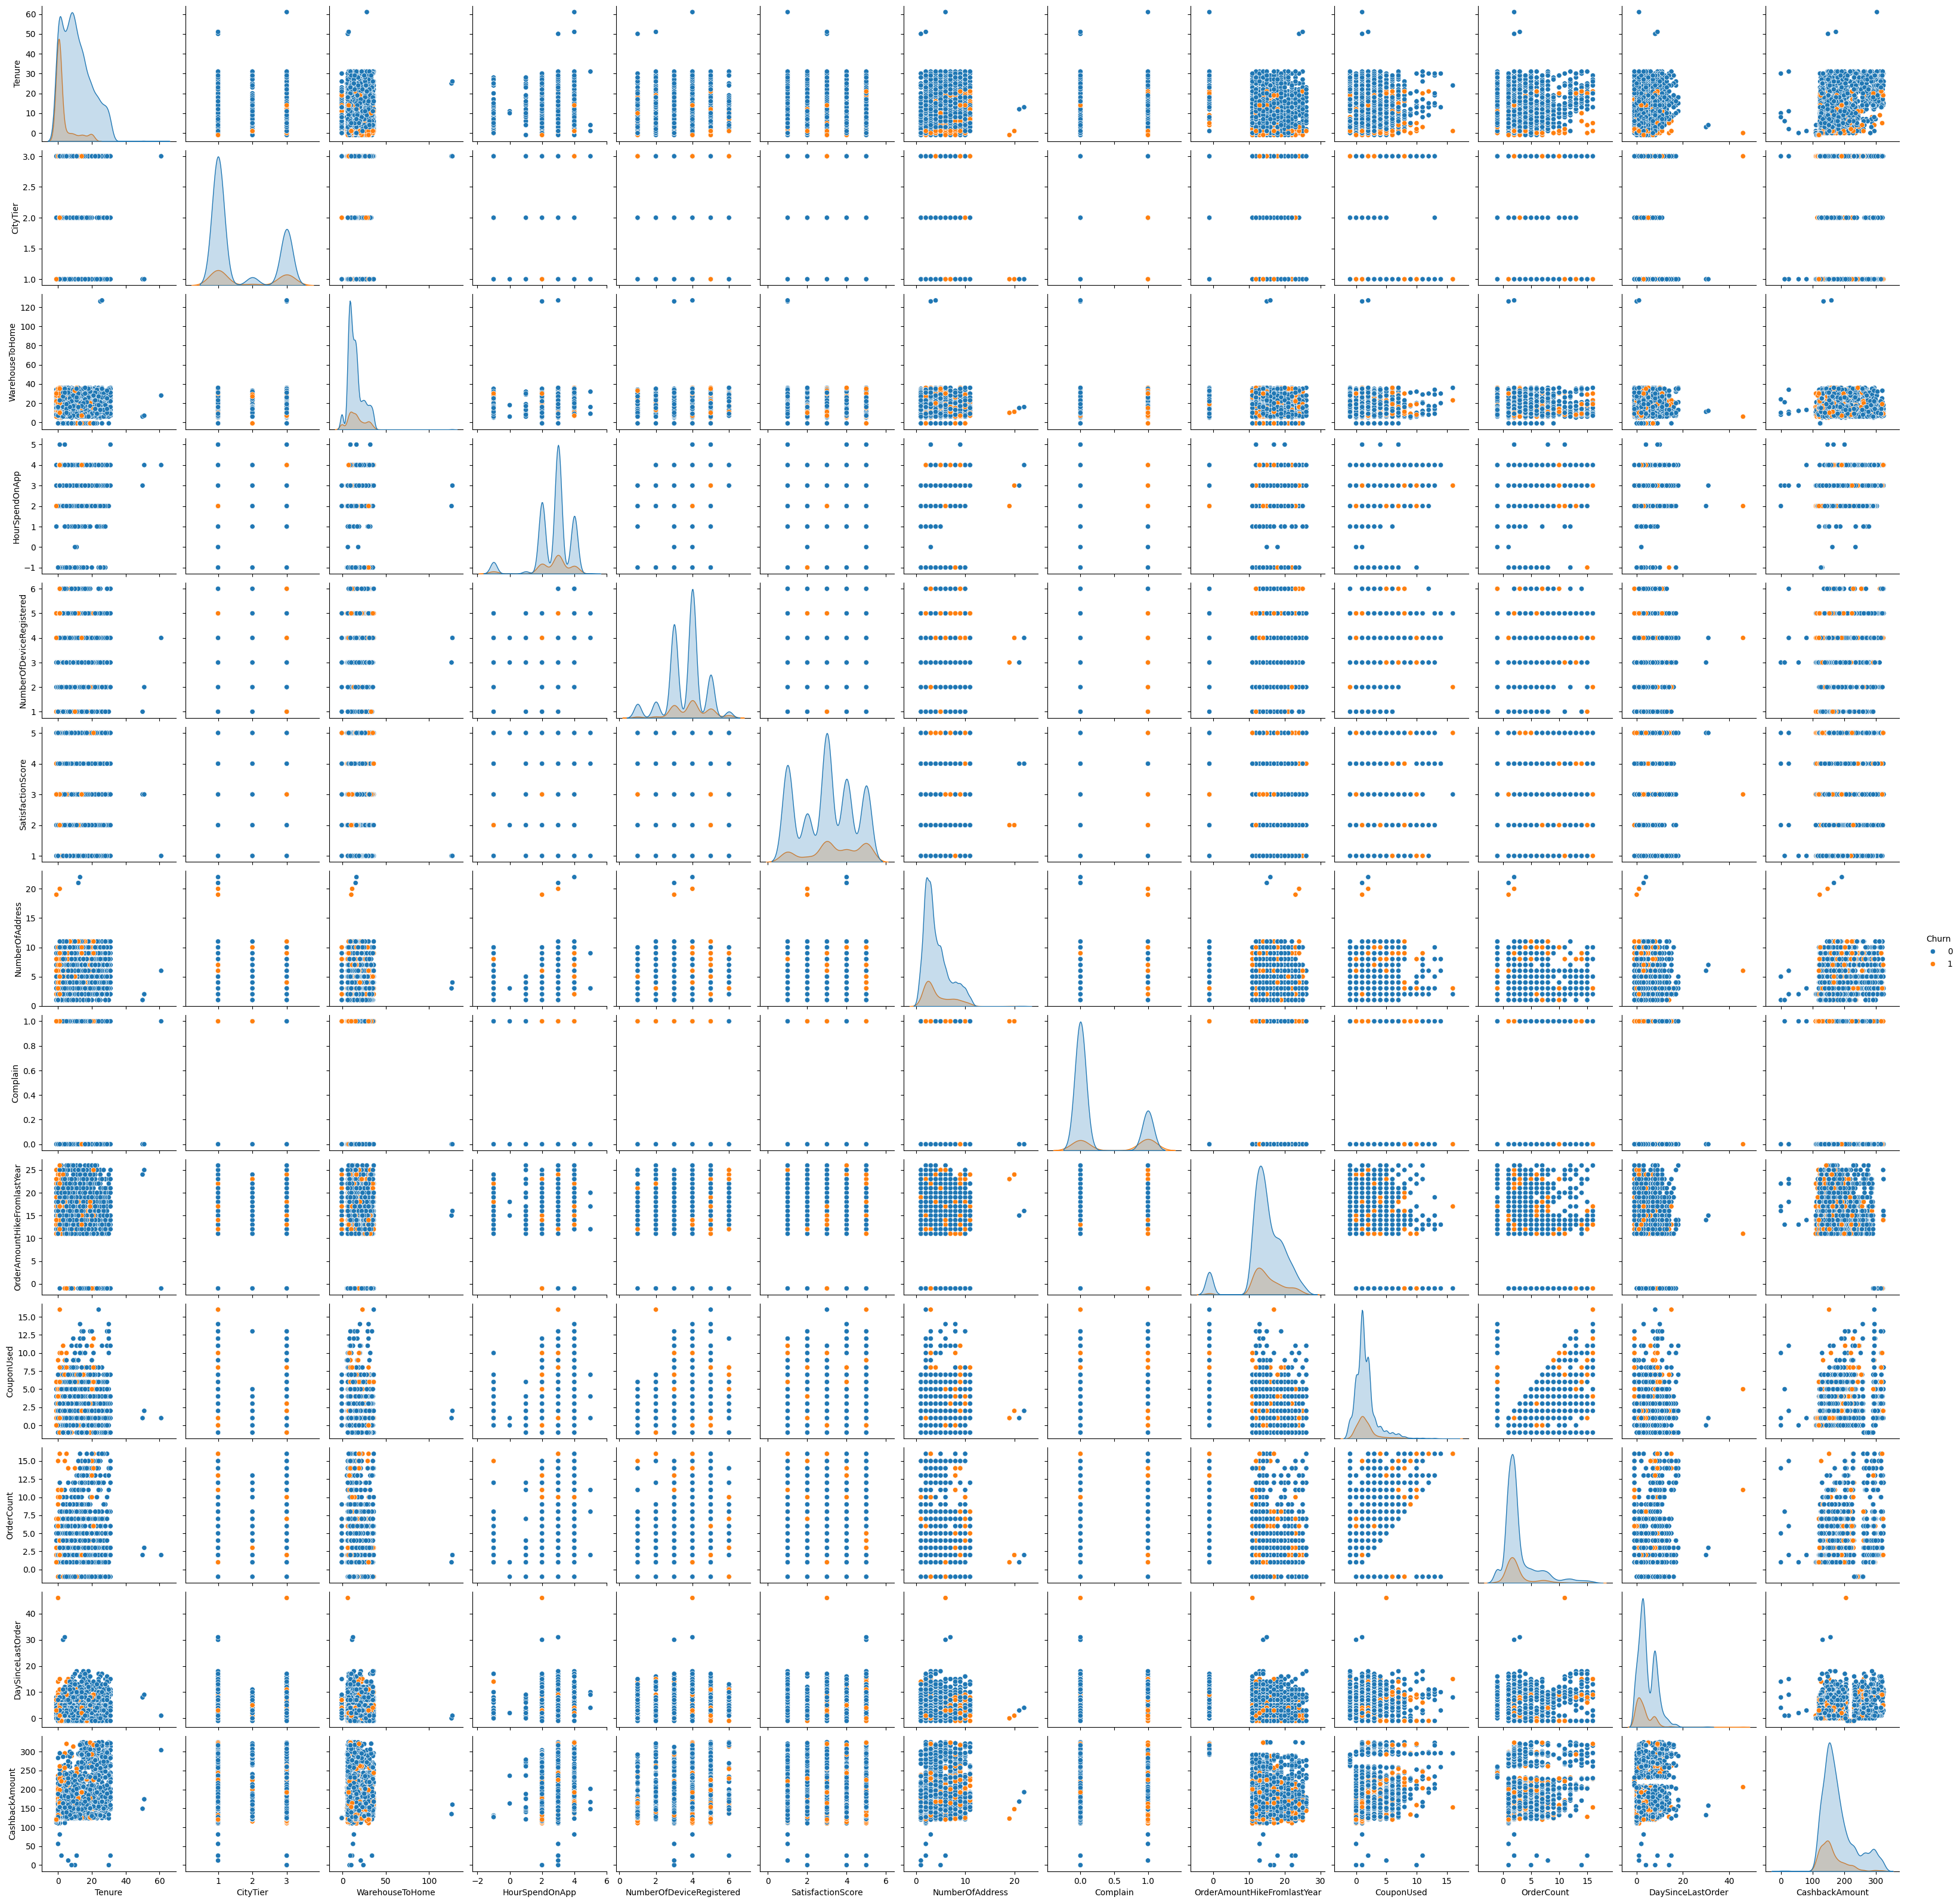

In [18]:
# Numerical-numerical variables
sns.pairplot(data = train, hue='Churn')
plt.show()

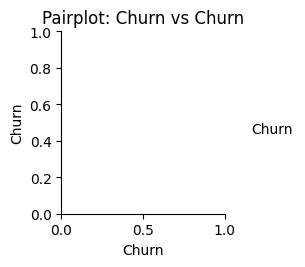

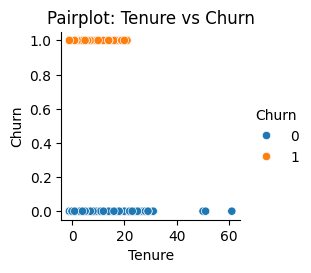

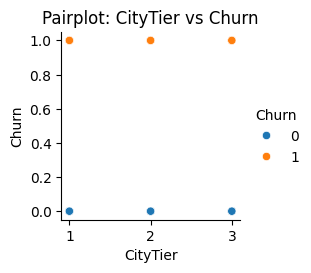

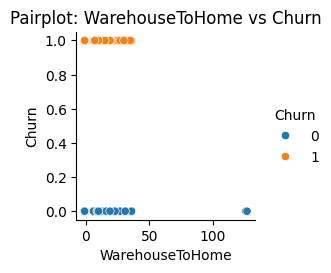

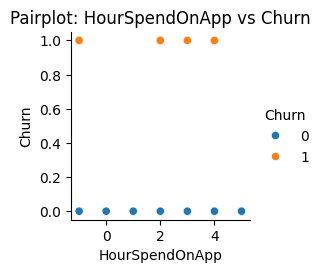

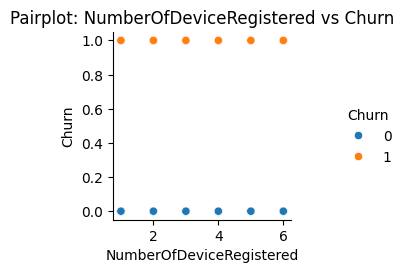

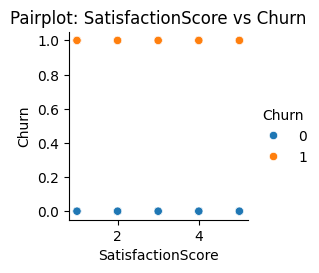

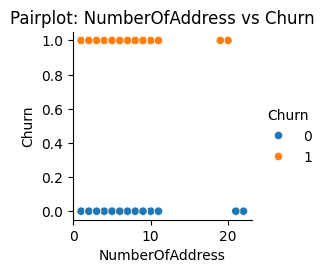

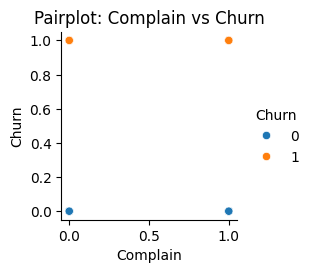

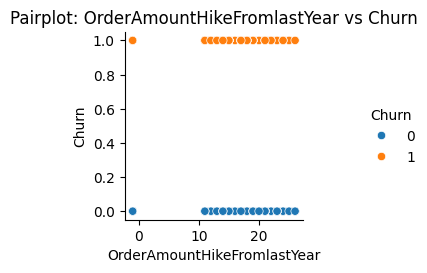

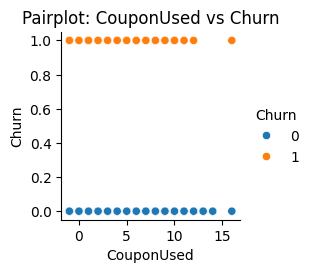

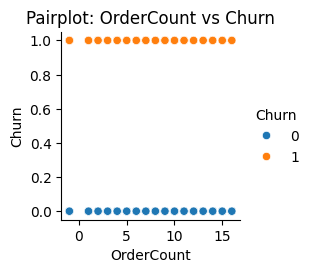

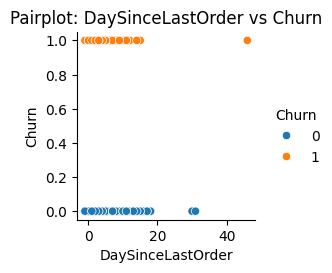

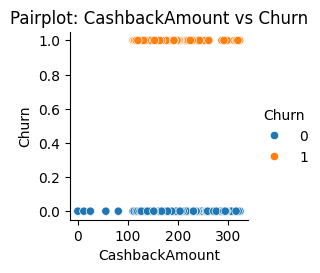

In [19]:
# Dependent variable
dependent_var = "Churn"

# Independent variables (only numeric ones)
independent_vars = train.select_dtypes(include=["number"]).columns

# Plot each independent variable vs the dependent variable
for col in independent_vars:
    sns.pairplot(train, x_vars=col, y_vars=dependent_var, hue=dependent_var, kind="scatter")
    plt.title(f"Pairplot: {col} vs {dependent_var}")
    plt.show()

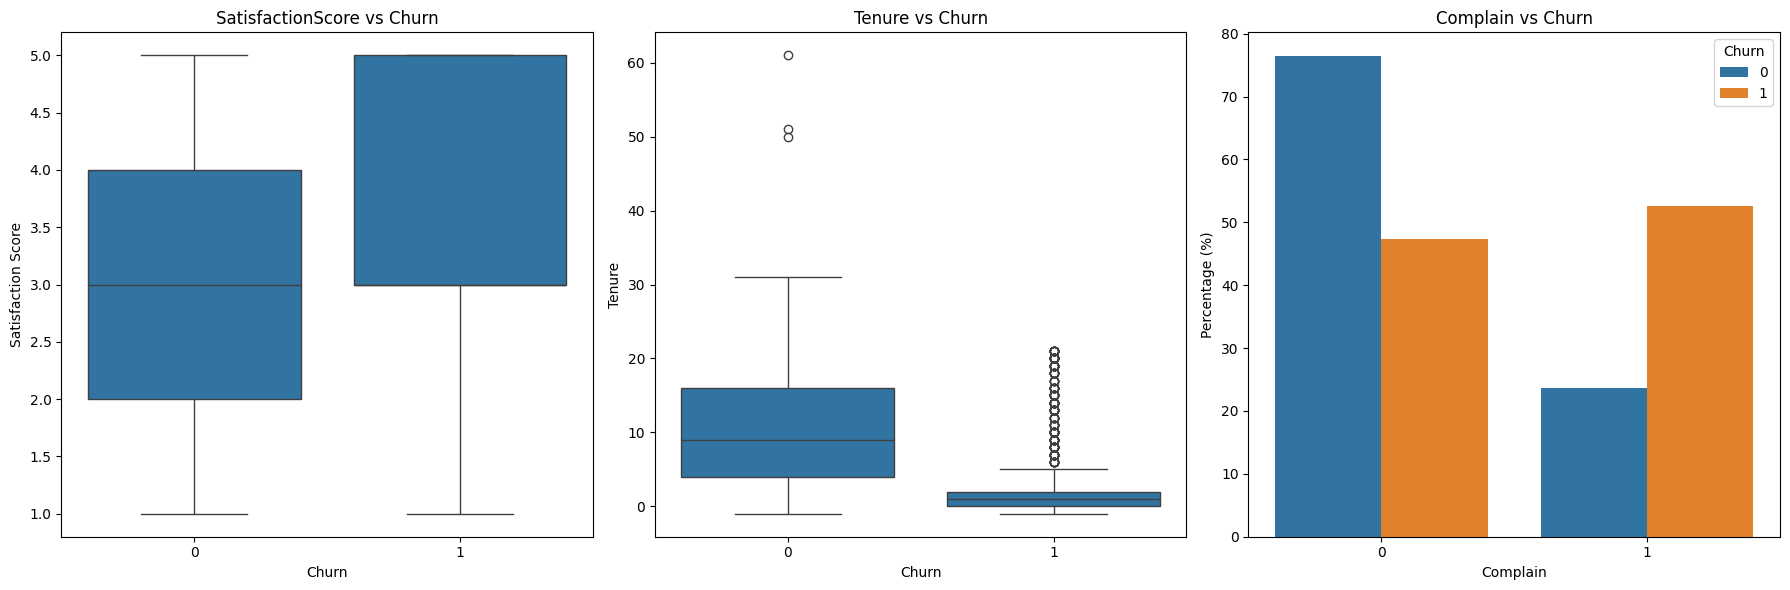

In [20]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot 1: SatisfactionScore vs Churn
sns.boxplot(x='Churn', y='SatisfactionScore', data=train, ax=axes[0])
axes[0].set_title('SatisfactionScore vs Churn')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Satisfaction Score')

# Plot 2: Tenure vs Churn
sns.boxplot(x='Churn', y='Tenure', data=train, ax=axes[1])
axes[1].set_title('Tenure vs Churn')
axes[1].set_xlabel('Churn')
axes[1].set_ylabel('Tenure')

# Plot 3: Complain vs Churn (Bar Chart)
counts = (
    train.groupby(['Churn'])['Complain']
    .value_counts(normalize=True)
    .rename('percentage')
    .mul(100)
    .reset_index()
)
sns.barplot(x="Complain", y="percentage", hue="Churn", data=counts, ax=axes[2])
axes[2].set_title('Complain vs Churn')
axes[2].set_xlabel('Complain')
axes[2].set_ylabel('Percentage (%)')

# Adjust layout
plt.tight_layout()
plt.show()

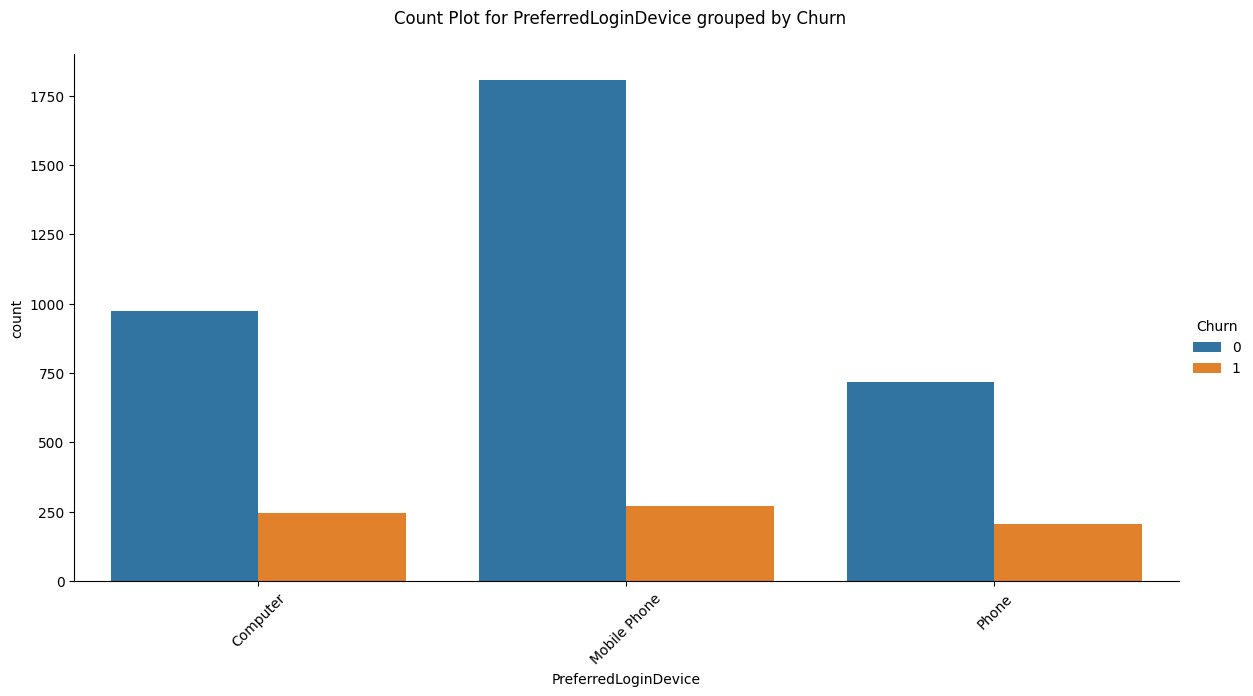

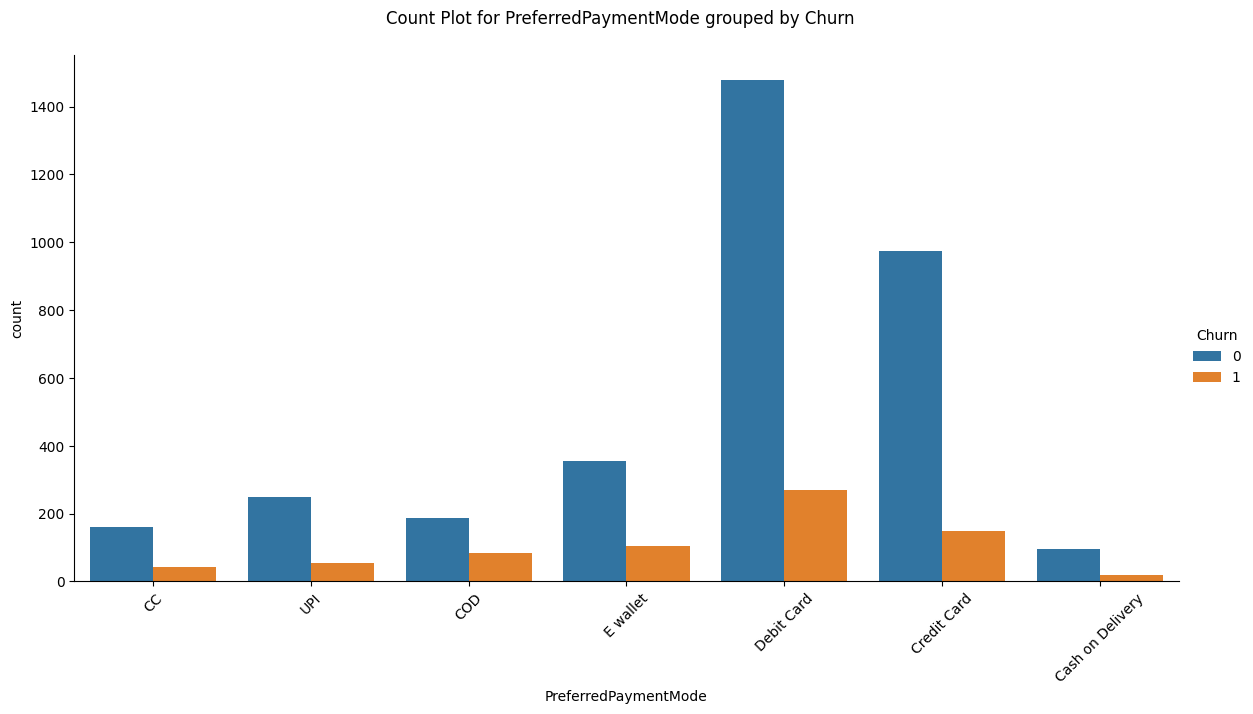

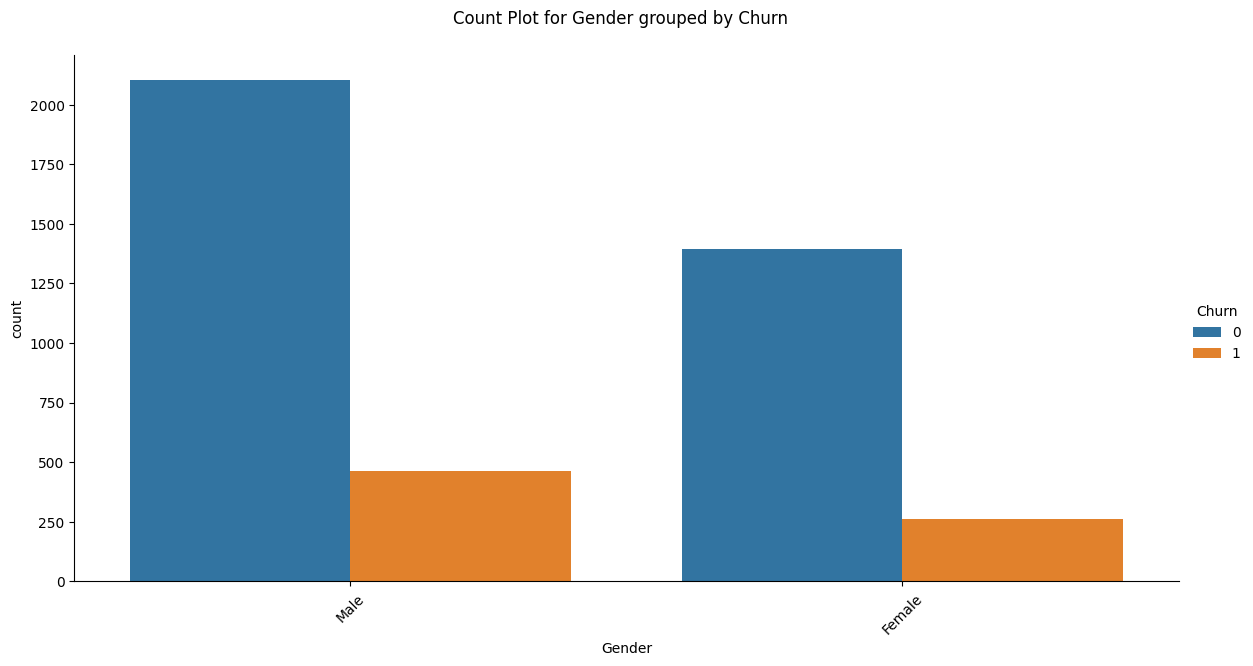

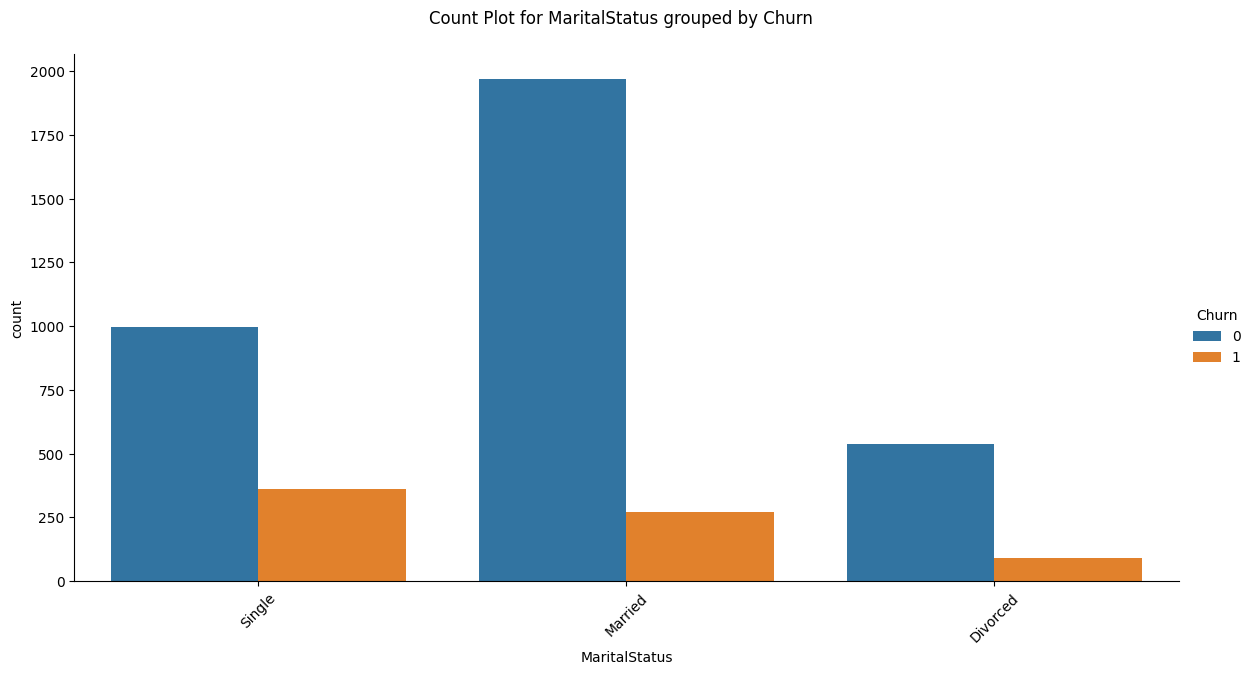

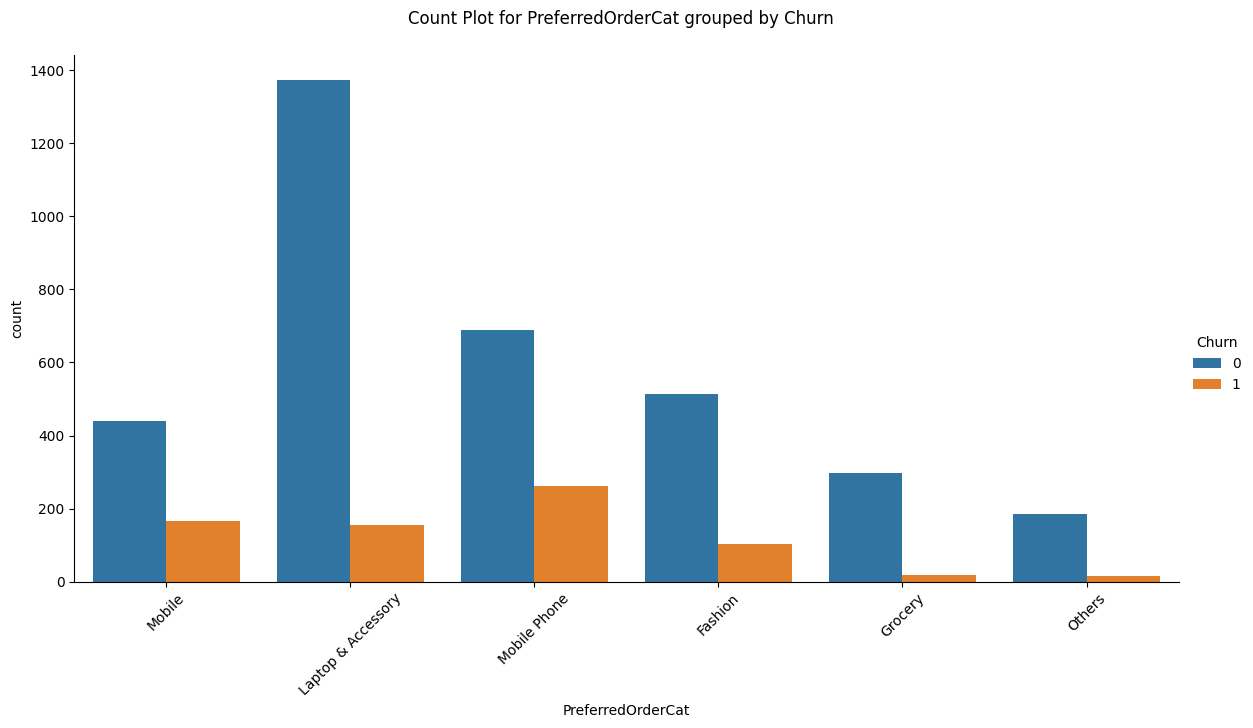

In [21]:
# Iterate over categorical columns
for col in train.select_dtypes(exclude=np.number).columns:
    # Ensure the 'Churn' column is in the data subset
    subset_df = train[[col, 'Churn']].dropna()  # Drop missing values if necessary
    
    # Create the catplot with increased x-axis space
    g = sns.catplot(
        x=col, kind='count', hue='Churn', data=subset_df, 
        height=6, aspect=2  # Adjust height and aspect for more space
    )
    
    # Set title and adjust x-axis labels
    g.fig.suptitle(f'Count Plot for {col} grouped by Churn', y=1.05)  # y adjusts title position
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    
    plt.show()

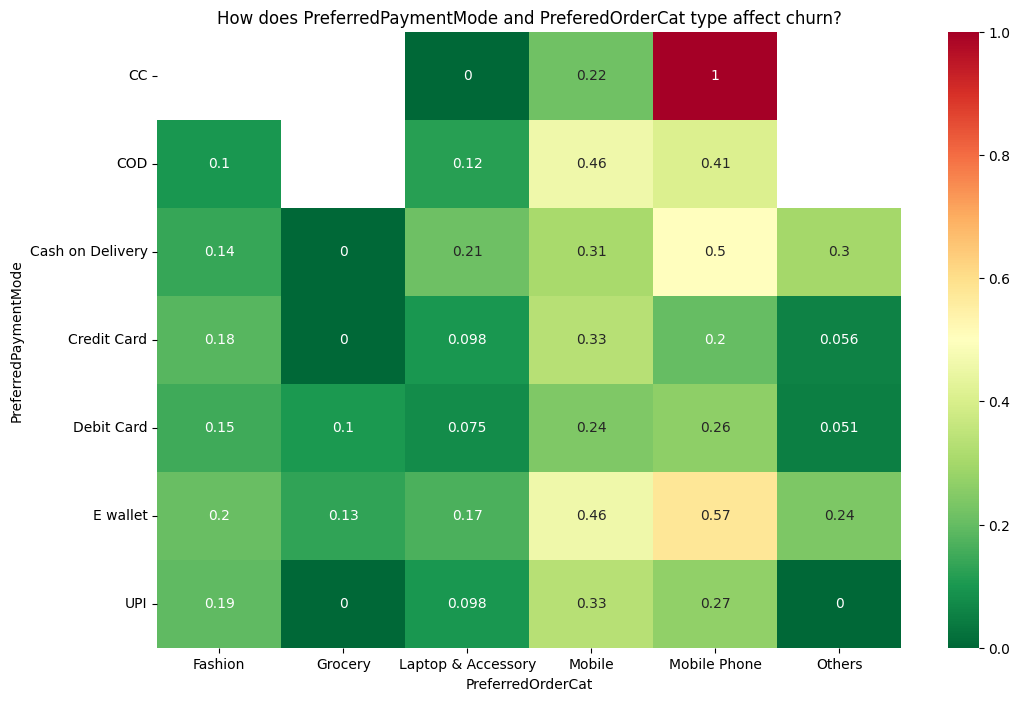

In [22]:
# Create pivot table
result = pd.pivot_table(
    data=train,
    index='PreferredPaymentMode',
    columns='PreferredOrderCat',
    values='Churn'
)

# Resize the chart by adjusting the figure size
plt.figure(figsize=(12, 8))  # Set width=12 and height=8

# Create heatmap
sns.heatmap(result, annot=True, cmap='RdYlGn_r').set_title(
    'How does PreferredPaymentMode and PreferedOrderCat type affect churn?'
)

# Show the plot
plt.show()

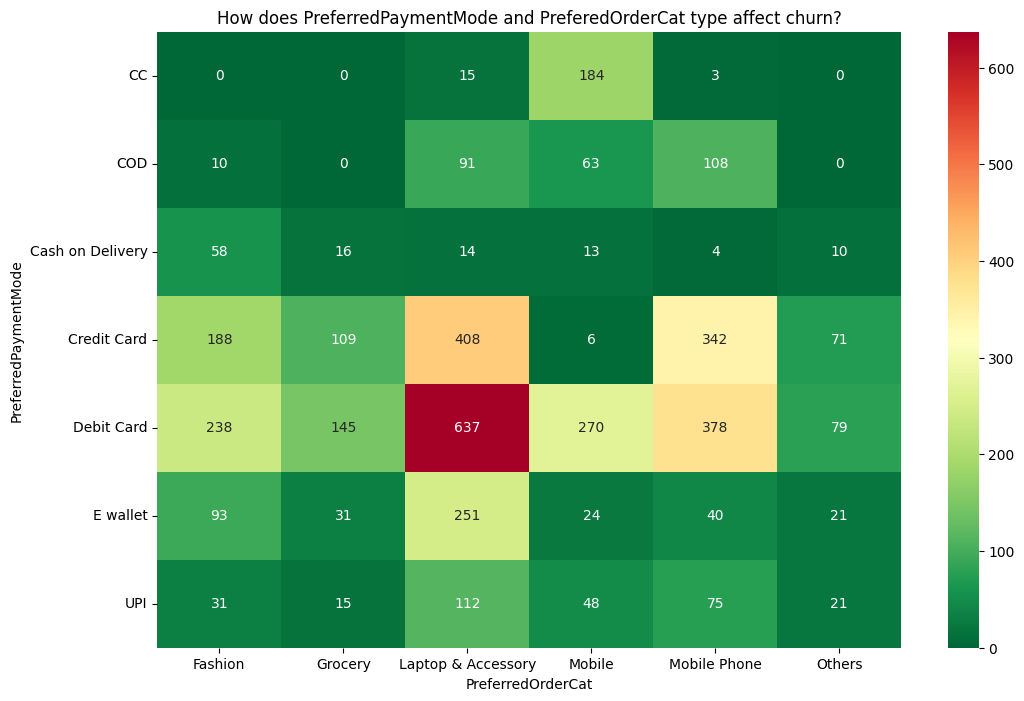

In [23]:
# Create pivot table with total counts
result = pd.pivot_table(
    data=train,
    index='PreferredPaymentMode',
    columns='PreferredOrderCat',
    aggfunc='size',  # Count occurrences
    fill_value=0     # Fill missing values with 0
)

# Resize the chart by adjusting the figure size
plt.figure(figsize=(12, 8))  # Adjust width and height as needed

# Create heatmap to visualize total counts
sns.heatmap(result, annot=True, fmt='d', cmap='RdYlGn_r').set_title(
    'How does PreferredPaymentMode and PreferedOrderCat type affect churn?'
)

plt.show()

In [24]:
'''
Learnings from exploratory data analysis
- Single and Married customers have a higher risk of churning
- Customer complaints increases the likelihood of churn
- Mobile customers have a higher risk of churn
- The longer the days since aa customer's last order, the higher the chance of them churning
'''

"\nLearnings from exploratory data analysis\n- Single and Married customers have a higher risk of churning\n- Customer complaints increases the likelihood of churn\n- Mobile customers have a higher risk of churn\n- The longer the days since aa customer's last order, the higher the chance of them churning\n"

In [25]:
# 2. Preprocessing

In [26]:
# 2.1 Imputation - SimpleImputer

    # All Nulls have been replaced

In [27]:
# Count NaN values for each column
nan_count_per_column = train.isna().sum()
print("NaN values per column:")
print(nan_count_per_column)

NaN values per column:
Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
PreferredOrderCat              0
dtype: int64


In [28]:
# List of columns to encode
columns_to_encode = ['PreferredLoginDevice', 'PreferredOrderCat', 'MaritalStatus', 'PreferredPaymentMode', 'Gender']

# Step 1: Handle missing values in the original columns
# Replace NaN values with a placeholder before encoding
train[columns_to_encode] = train[columns_to_encode].fillna('MISSING')

# Step 2: Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Step 3: Fit and transform the specified columns
encoded = encoder.fit_transform(train[columns_to_encode])

# Step 4: Create a DataFrame for the encoded columns
encoded_columns = encoder.get_feature_names_out(columns_to_encode)
encoded_df = pd.DataFrame(encoded, columns=encoded_columns)

# Step 5: Combine the original DataFrame with the encoded DataFrame
train = pd.concat([train.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Step 6: Drop the original columns (optional, if they are no longer needed)
train = train.drop(columns=columns_to_encode)

# Step 7: Ensure no NaN values are present
assert train.isna().sum().sum() == 0, "NaN values found in the DataFrame!"

# Print the resulting DataFrame
print(train)

      Churn  Tenure  CityTier  WarehouseToHome  HourSpendOnApp  \
0         0      -1         1                9             1.0   
1         0      11         2               -1             3.0   
2         0       6         3               15             4.0   
3         0       4         3               34             4.0   
4         0       0         1               25             3.0   
...     ...     ...       ...              ...             ...   
4217      0       7         1               16             3.0   
4218      1      -1         1               30             2.0   
4219      0       5         3               19             3.0   
4220      0       5         3               10             2.0   
4221      0       4         1               31             4.0   

      NumberOfDeviceRegistered  SatisfactionScore  NumberOfAddress  Complain  \
0                            3                  4                5         0   
1                            3                 

In [29]:
# Count NaN values for each column
nan_count_per_column = train.isna().sum()
print("NaN values per column:")
print(nan_count_per_column)

NaN values per column:
Churn                                    0
Tenure                                   0
CityTier                                 0
WarehouseToHome                          0
HourSpendOnApp                           0
NumberOfDeviceRegistered                 0
SatisfactionScore                        0
NumberOfAddress                          0
Complain                                 0
OrderAmountHikeFromlastYear              0
CouponUsed                               0
OrderCount                               0
DaySinceLastOrder                        0
CashbackAmount                           0
PreferredLoginDevice_Computer            0
PreferredLoginDevice_Mobile Phone        0
PreferredLoginDevice_Phone               0
PreferredOrderCat_Fashion                0
PreferredOrderCat_Grocery                0
PreferredOrderCat_Laptop & Accessory     0
PreferredOrderCat_Mobile                 0
PreferredOrderCat_Mobile Phone           0
PreferredOrderCat_Others       

In [30]:
# Filter rows where any column has NaN
rows_with_nan = train[train.isna().any(axis=1)]
print("Rows with NaN values:")
print(rows_with_nan)

Rows with NaN values:
Empty DataFrame
Columns: [Churn, Tenure, CityTier, WarehouseToHome, HourSpendOnApp, NumberOfDeviceRegistered, SatisfactionScore, NumberOfAddress, Complain, OrderAmountHikeFromlastYear, CouponUsed, OrderCount, DaySinceLastOrder, CashbackAmount, PreferredLoginDevice_Computer, PreferredLoginDevice_Mobile Phone, PreferredLoginDevice_Phone, PreferredOrderCat_Fashion, PreferredOrderCat_Grocery, PreferredOrderCat_Laptop & Accessory, PreferredOrderCat_Mobile, PreferredOrderCat_Mobile Phone, PreferredOrderCat_Others, MaritalStatus_Divorced, MaritalStatus_Married, MaritalStatus_Single, PreferredPaymentMode_CC, PreferredPaymentMode_COD, PreferredPaymentMode_Cash on Delivery, PreferredPaymentMode_Credit Card, PreferredPaymentMode_Debit Card, PreferredPaymentMode_E wallet, PreferredPaymentMode_UPI, Gender_Female, Gender_Male]
Index: []

[0 rows x 35 columns]


In [31]:
train.dtypes

Churn                                      int64
Tenure                                     Int64
CityTier                                   int64
WarehouseToHome                            Int64
HourSpendOnApp                           float64
NumberOfDeviceRegistered                   int64
SatisfactionScore                          int64
NumberOfAddress                            int64
Complain                                   int64
OrderAmountHikeFromlastYear                Int64
CouponUsed                                 Int64
OrderCount                                 Int64
DaySinceLastOrder                          Int64
CashbackAmount                           float64
PreferredLoginDevice_Computer            float64
PreferredLoginDevice_Mobile Phone        float64
PreferredLoginDevice_Phone               float64
PreferredOrderCat_Fashion                float64
PreferredOrderCat_Grocery                float64
PreferredOrderCat_Laptop & Accessory     float64
PreferredOrderCat_Mo

In [32]:
# 2.3 Scaling - StandardScaler

In [33]:
X = train.drop(columns='Churn', axis=1)
y = train['Churn']

In [34]:

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data (standardize)
scaled_data = scaler.fit_transform(X)

# Create a new DataFrame with the scaled data
X = pd.DataFrame(scaled_data, columns=X.columns)

In [35]:
# 2.4 Feature Selection - SelectKBest
# Initialize SelectKBest with ANOVA F-value as the scoring function
k_best = SelectKBest(score_func=f_classif, k=2)  # Select top 2 features

# Fit and transform the data
X_selected = k_best.fit_transform(X, y)

# Get the scores of the features
feature_scores = k_best.scores_

# Display results
print("Feature Scores:", feature_scores)
print("Selected Features:\n", X.iloc[:, k_best.get_support(indices=True)].head())

Feature Scores: [5.55086095e+02 3.30207344e+01 5.31554084e+00 1.31280376e+00
 4.19007591e+01 4.56859315e+01 9.19992254e+00 2.62473614e+02
 7.00194468e+00 2.99688064e+00 2.41815369e-01 9.11875051e+01
 9.56387624e+01 1.07781478e+01 4.82843205e+01 2.27954764e+01
 3.78819816e-02 2.98182253e+01 8.33289024e+01 5.45095432e+01
 9.50871387e+01 1.26433975e+01 3.19332900e+00 8.66590844e+01
 1.29574748e+02 2.62291808e+00 4.14397384e+01 7.02948672e-03
 1.60248239e+01 6.52098669e+00 1.10707278e+01 4.61864581e-02
 3.45248551e+00 3.45248551e+00]
Selected Features:
      Tenure  Complain
0 -1.223124 -0.632351
1  0.159265 -0.632351
2 -0.416730  1.581401
3 -0.647129 -0.632351
4 -1.107925 -0.632351


In [36]:
# Initialize SelectKBest with ANOVA F-value as the scoring function
k_best = SelectKBest(score_func=f_classif, k=2)  # Select top 2 features

# Fit and transform the data
k_best.fit(X, y)  # Fit only to get scores without transforming here

# Get the scores of the features
feature_scores = k_best.scores_

# Combine feature names with their scores
feature_scores_df = pd.DataFrame({
    "Feature": X.columns,
    "Score": feature_scores
}).sort_values(by="Score", ascending=False)

# Display results
print("Feature Scores:")
print(feature_scores_df)

# Display the selected features
selected_features = X.columns[k_best.get_support(indices=True)]
print("\nSelected Features (Top 2):")
print(selected_features)

Feature Scores:
                                  Feature       Score
0                                  Tenure  555.086095
7                                Complain  262.473614
24                   MaritalStatus_Single  129.574748
12                         CashbackAmount   95.638762
20         PreferredOrderCat_Mobile Phone   95.087139
11                      DaySinceLastOrder   91.187505
23                  MaritalStatus_Married   86.659084
18   PreferredOrderCat_Laptop & Accessory   83.328902
19               PreferredOrderCat_Mobile   54.509543
14      PreferredLoginDevice_Mobile Phone   48.284320
5                       SatisfactionScore   45.685932
4                NumberOfDeviceRegistered   41.900759
26               PreferredPaymentMode_COD   41.439738
1                                CityTier   33.020734
17              PreferredOrderCat_Grocery   29.818225
15             PreferredLoginDevice_Phone   22.795476
28       PreferredPaymentMode_Credit Card   16.024824
21          

In [37]:
# Create a pipeline with SelectKBest and a classifier
pipeline = Pipeline(steps=[
    ('feature_selection', SelectKBest(score_func=f_classif, k=2)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Perform cross-validation
scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')

print("Cross-Validation Scores:", scores)
print("Mean Accuracy:", scores.mean())

Cross-Validation Scores: [0.87218935 0.85798817 0.87914692 0.87085308 0.86137441]
Mean Accuracy: 0.8683103844751676


In [38]:
# 3. Training Time — Model building and comparison

# Data Splitting
# Before starting we have to make sure we include the right data in our model. We’ll split it into training and test and separate features from the target.

'''
train, test = train_test_split(train, test_size=0.25, random_state=123)
X = train.drop(columns='Churn', axis=1)
y = train['Churn']
'''

"\ntrain, test = train_test_split(train, test_size=0.25, random_state=123)\nX = train.drop(columns='Churn', axis=1)\ny = train['Churn']\n"

In [39]:
# Building the pipeline

## Selecting categorical and numeric features
numerical_ix = X.select_dtypes(include=np.number).columns
categorical_ix = X.select_dtypes(exclude=np.number).columns
## Create preprocessing pipelines for each datatype
numerical_transformer = Pipeline(steps=[
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[
('encoder', OrdinalEncoder()),
('scaler', StandardScaler())])
## Putting the preprocessing steps together
preprocessor = ColumnTransformer([
('numerical', numerical_transformer, numerical_ix),
('categorical', categorical_transformer, categorical_ix)],
remainder='passthrough')

In [40]:
# Finding the best baseline model

## Creat list of classifiers we're going to try out
classifiers = [
KNeighborsClassifier(),
SVC(random_state=123),
DecisionTreeClassifier(random_state=123),
RandomForestClassifier(random_state=123),
AdaBoostClassifier(random_state=123),
GradientBoostingClassifier(random_state=123)
]
classifier_names = [
'KNeighborsClassifier()',
'SVC()',
'DecisionTreeClassifier()',
'RandomForestClassifier()',
'AdaBoostClassifier()',
'GradientBoostingClassifier()'
] 
model_scores = []

In [41]:
## Looping through the classifiers
for classifier, name in zip(classifiers, classifier_names):
  pipe = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('selector', SelectKBest(k=len(X.columns))),
  ('classifier', classifier)])
  score = cross_val_score(pipe, X, y, cv=10, scoring='roc_auc').mean() 
  model_scores.append(score)

In [42]:
model_performance = pd.DataFrame({
  'Classifier':
    classifier_names,  
  'Cross-validated AUC':
    model_scores
}).sort_values('Cross-validated AUC', ascending = False, ignore_index=True)
display(model_performance)

,Classifier,Cross-validated AUC
0,RandomForestClassifier(),0.984548
1,GradientBoostingClassifier(),0.931780
2,SVC(),0.923040
3,DecisionTreeClassifier(),0.902270
4,AdaBoostClassifier(),0.898030
5,KNeighborsClassifier(),0.884733


In [43]:
# Dictionary to store feature importance
feature_importances = {}

for classifier, name in zip(classifiers, classifier_names):
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', SelectKBest(k=len(X.columns))),
        ('classifier', classifier)
    ])
    
    # Perform cross-validation and fit the pipeline
    score = cross_val_score(pipe, X, y, cv=10, scoring='roc_auc').mean()
    model_scores.append(score)
    
    # Fit the pipeline to extract feature importance
    pipe.fit(X, y)
    model = pipe.named_steps['classifier']
    
    # Save feature importance or coefficients based on classifier type
    if hasattr(model, 'feature_importances_'):  # Tree-based models
        feature_importances[name] = model.feature_importances_
    elif hasattr(model, 'coef_'):  # Linear models
        feature_importances[name] = model.coef_.ravel()
    else:
        feature_importances[name] = None  # Not applicable for this model

# Create a DataFrame to display feature importance for each model
feature_importance_df = pd.DataFrame(feature_importances, index=X.columns)
display(feature_importance_df)

,KNeighborsClassifier(),SVC(),DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier(),GradientBoostingClassifier()
Tenure,None,None,0.283816,0.202971,0.579492,0.475467
CityTier,None,None,0.022933,0.023451,0.032254,0.011743
WarehouseToHome,None,None,0.075032,0.070741,0.025733,0.035698
HourSpendOnApp,None,None,0.022709,0.023229,0.000000,0.002874
NumberOfDeviceRegistered,None,None,0.036296,0.037356,0.032037,0.028051
SatisfactionScore,None,None,0.034500,0.046706,0.022783,0.037546
NumberOfAddress,None,None,0.057434,0.060950,0.065457,0.084268
Complain,None,None,0.061685,0.060646,0.055767,0.112486
OrderAmountHikeFromlastYear,None,None,0.045288,0.055306,0.000000,0.004054
CouponUsed,None,None,0.015711,0.027732,0.039066,0.010627


In [44]:
# Did KNeighborsClassifier() and SVC() not run?

# Top Features for DecisionTreeClassifier

""" 
Tenure	0.281132
NumberOfAddress	0.084267
WarehouseToHome	0.070501
CashbackAmount	0.067307
DaySinceLastOrder	0.066563
"""
# Top Features for RandomForestClassifier

""" 
Tenure	0.203657
CashbackAmount	0.084967
WarehouseToHome	0.070548
Complain	0.064087
DaySinceLastOrder  0.061763 
"""
# Top Features for AdaBoostClassifier

""" 
Tenure 0.548477
NumberOfAddress 0.062266
Complain 0.057591
DaySinceLastOrder 0.045511
WarehouseToHome 0.042115
"""

# Top Features for GradientBoostingClassifier

""" 
Tenure 0.460891
Complain 0.113261
NumberOfAddress 0.087082
DaySinceLastOrder 0.055379
CashbackAmount 0.046176
"""

#Consisently the top features are Tenure, Complain, NumberOfAddress, DaySinceLastOrder, CashbackAmount, WarehouseToHome

# This makes sense that Tenure and DaySinceLastOrder are so closely related to churn (and Complain and CashbackAmount make sense), 
# but NumberOfAddress and WarehouseToHome are surprising

' \nTenure 0.460891\nComplain 0.113261\nNumberOfAddress 0.087082\nDaySinceLastOrder 0.055379\nCashbackAmount 0.046176\n'

In [45]:
## Code added to avoid missing k_range error

# Define k_range as a range of integers
k_range = range(1, len(X.columns) + 1)  # 1 to number of columns in X

In [46]:
# Hyperparameter Tuning

pipe = Pipeline(steps=[
  ('preprocessor', preprocessor),
  ('selector', SelectKBest(k=len(X.columns))),
  ('classifier', GradientBoostingClassifier(random_state=123))
])
# Full list of all hyperparameters
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'preprocessor', 'selector', 'classifier', 'preprocessor__force_int_remainder_cols', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__numerical', 'preprocessor__categorical', 'preprocessor__numerical__memory', 'preprocessor__numerical__steps', 'preprocessor__numerical__transform_input', 'preprocessor__numerical__verbose', 'preprocessor__numerical__imputer', 'preprocessor__numerical__scaler', 'preprocessor__numerical__imputer__add_indicator', 'preprocessor__numerical__imputer__copy', 'preprocessor__numerical__imputer__fill_value', 'preprocessor__numerical__imputer__keep_empty_features', 'preprocessor__numerical__imputer__missing_values', 'preprocessor__numerical__imputer__strategy', 'preprocessor__numerical__scaler__copy', 'preprocessor__numerica

In [47]:
# Define the parameter grid
grid = {
    "selector__k": k_range,
    "classifier__max_depth": [1, 3, 5],
    "classifier__learning_rate": [0.01, 0.1, 1],
    "classifier__n_estimators": [100, 200, 300]
}

# Use RandomizedSearchCV for faster exploration
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=grid,
    n_iter=20,  # Number of parameter combinations to sample
    n_jobs=-1,  # Use all available cores
    scoring='roc_auc',
    cv=3,  # Reduced cross-validation folds
    random_state=42
)

# Fit the model
random_search.fit(X, y)

# Print best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best ROC AUC Score:", random_search.best_score_)

Best Parameters: {'selector__k': 26, 'classifier__n_estimators': 100, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.1}
Best ROC AUC Score: 0.9620915518086471


In [48]:
# Use the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Generate predictions and probabilities for the test data
y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)[:, 1]

NameError: name 'X_test' is not defined

In [49]:
# 4. Creating predictions for unseen data

In [50]:
# 4.1 Create Data Transformations for test dataset

print(missing_values(test))

# Why has data for test dataset already been transformed?

                       variable  Unique values  Nan %  zeros %
18            DaySinceLastOrder             20    5.7      8.0
17                   OrderCount             17    5.0      0.0
8                HourSpendOnApp              6    4.5      0.1
5               WarehouseToHome             33    4.5      0.0
16                   CouponUsed             17    4.0     19.1
15  OrderAmountHikeFromlastYear             17    4.0      0.0
2                        Tenure             34    3.8      8.7
0                    CustomerID           1408    0.0      0.0
3          PreferredLoginDevice              3    0.0      0.0
1                         Churn              2    0.0     83.9
6          PreferredPaymentMode              7    0.0      0.0
4                      CityTier              3    0.0      0.0
11            SatisfactionScore              5    0.0      0.0
10             PreferedOrderCat              6    0.0      0.0
9      NumberOfDeviceRegistered              6    0.0  

In [51]:
# Replace missing values with -1 and recast values for Test data
test['Tenure'] = test['Tenure'].fillna(-1).astype('Int64')
test['WarehouseToHome'] = test['WarehouseToHome'].fillna(-1).astype('Int64')
test['OrderAmountHikeFromlastYear'] = test['OrderAmountHikeFromlastYear'].fillna(-1).astype('Int64')
test['CouponUsed'] = test['CouponUsed'].fillna(-1).astype('Int64')
test['OrderCount'] = test['OrderCount'].fillna(-1).astype('Int64')
test['DaySinceLastOrder'] = test['DaySinceLastOrder'].fillna(-1).astype('Int64')

#Filling in Nulls but don't need to recast
test['HourSpendOnApp'] = test['HourSpendOnApp'].fillna(-1)
test['DaySinceLastOrder'] = test['DaySinceLastOrder'].fillna(-1)

#PreferedOrderCat is misspelled
test['PreferredOrderCat'] = test['PreferedOrderCat']

#Remove PreferedOrderCat and CustomerID from the dataframe
test = test.drop(columns=['PreferedOrderCat'])
test = test.drop(columns=['CustomerID'])

In [52]:
# List of columns to encode for Test data
columns_to_encode = ['PreferredLoginDevice', 'PreferredOrderCat', 'MaritalStatus', 'PreferredPaymentMode', 'Gender']

# Step 1: Handle missing values in the original columns
# Replace NaN values with a placeholder before encoding
test[columns_to_encode] = test[columns_to_encode].fillna('MISSING')

# Step 2: Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Step 3: Fit and transform the specified columns
encoded = encoder.fit_transform(test[columns_to_encode])

# Step 4: Create a DataFrame for the encoded columns
encoded_columns = encoder.get_feature_names_out(columns_to_encode)
encoded_df = pd.DataFrame(encoded, columns=encoded_columns)

# Step 5: Combine the original DataFrame with the encoded DataFrame
test = pd.concat([test.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Step 6: Drop the original columns (optional, if they are no longer needed)
test = test.drop(columns=columns_to_encode)

# Step 7: Ensure no NaN values are present
assert test.isna().sum().sum() == 0, "NaN values found in the DataFrame!"

# Print the resulting DataFrame
print(test)

      Churn  Tenure  CityTier  WarehouseToHome  HourSpendOnApp  \
0         0      11         3                8             2.0   
1         0      10         3                7             3.0   
2         1       0         1               21             2.0   
3         0      20         1                8             2.0   
4         0       2         1                6            -1.0   
...     ...     ...       ...              ...             ...   
1403      0       8         1               26             3.0   
1404      1       0         1               30             3.0   
1405      0      16         1                9             3.0   
1406      0       8         1               23             4.0   
1407      0      10         3               22             3.0   

      NumberOfDeviceRegistered  SatisfactionScore  NumberOfAddress  Complain  \
0                            3                  5                4         0   
1                            4                 

In [53]:
# Scaling Test Data - StandardScaler

X_test = test.drop(columns='Churn', axis=1)
y_test = test['Churn']


# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data (standardize)
scaled_data = scaler.fit_transform(X_test)

# Create a new DataFrame with the scaled data
X_test = pd.DataFrame(scaled_data, columns=X_test.columns)

In [54]:
## Code added to avoid NotFittedError: This GridSearchCV instance is not fitted yet error later
'''
# Fit GridSearchCV
gridsearch = GridSearchCV(estimator=pipe, param_grid=grid, n_jobs=1, scoring='roc_auc')
gridsearch.fit(X, y)  # Ensure X and y are properly defined

'''

"\n# Fit GridSearchCV\ngridsearch = GridSearchCV(estimator=pipe, param_grid=grid, n_jobs=1, scoring='roc_auc')\ngridsearch.fit(X, y)  # Ensure X and y are properly defined\n\n"

In [55]:
'''
# Separate features and target for the test data
X_test = test.drop(columns='Churn', axis=1)
y_test = test['Churn']

# Refitting the model with the best parameters after grid search (if necessary)
gridsearch.refit  # This line ensures the model is refitted with the best parameters after the grid search

# Creating the predictions
y_pred = gridsearch.predict(X_test)
y_score = gridsearch.predict_proba(X_test)[:, 1]

# Printing performance metrics
print('AUCROC:', roc_auc_score(y_test, y_score), '\nAccuracy:', accuracy_score(y_test, y_pred))

# Manually plotting the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random model
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
'''

"\n# Separate features and target for the test data\nX_test = test.drop(columns='Churn', axis=1)\ny_test = test['Churn']\n\n# Refitting the model with the best parameters after grid search (if necessary)\ngridsearch.refit  # This line ensures the model is refitted with the best parameters after the grid search\n\n# Creating the predictions\ny_pred = gridsearch.predict(X_test)\ny_score = gridsearch.predict_proba(X_test)[:, 1]\n\n# Printing performance metrics\nprint('AUCROC:', roc_auc_score(y_test, y_score), '\nAccuracy:', accuracy_score(y_test, y_pred))\n\n# Manually plotting the ROC curve\nfpr, tpr, _ = roc_curve(y_test, y_score)\nroc_auc = auc(fpr, tpr)\n\nplt.figure(figsize=(8, 6))\nplt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')\nplt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random model\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel('False Positive Rate')\nplt.ylabel('True Positive Rate')\nplt.title('Receive

In [56]:
# Performance metrics
print('AUCROC:', roc_auc_score(y_test, y_score))
print('Accuracy:', accuracy_score(y_test, y_pred))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random model
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

NameError: name 'y_score' is not defined

In [ ]:
print(len(X_test), len(y_test), len(y_pred), len(y_score))

In [ ]:
'''
# Deciling Model Performance

# Generate predictions and probabilities using the best model
y_pred = random_search.best_estimator_.predict(X_test)
y_score = random_search.best_estimator_.predict_proba(X_test)[:, 1]

# Create a DataFrame to hold actual values and predicted probabilities
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted_Prob': y_score
})

# Apply pandas.qcut to divide the probabilities into 10 deciles
results_df['Decile'] = pd.qcut(results_df['Predicted_Prob'], q=10, labels=False, duplicates='drop') + 1

# Analyze the deciles
decile_summary = results_df.groupby('Decile').agg(
    Count=('Actual', 'size'),
    Avg_Probability=('Predicted_Prob', 'mean'),
    Actual_Rate=('Actual', 'mean')
).sort_index(ascending=False)

# Display decile analysis
print(decile_summary)

# Plot decile performance
plt.figure(figsize=(10, 6))
plt.bar(decile_summary.index, decile_summary['Actual_Rate'], alpha=0.7, label='Actual Positive Rate')
plt.xlabel('Decile (10 = Highest Predicted Probability)')
plt.ylabel('Actual Positive Rate')
plt.title('Decile Analysis of Model Predictions')
plt.xticks(decile_summary.index)
plt.legend()
plt.show()

# Optional: Feature Importance Analysis
if hasattr(random_search.best_estimator_.named_steps['classifier'], 'feature_importances_'):
    feature_importance = random_search.best_estimator_.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    print(feature_importance_df)

'''


In [ ]:
'''
# Generate predictions and probabilities using the best model
y_pred = random_search.best_estimator_.predict(X_test)
y_score = random_search.best_estimator_.predict_proba(X_test)[:, 1]

# Create a DataFrame to hold actual values and predicted probabilities
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted_Prob': y_score
})

# Apply pandas.qcut to divide the probabilities into 4 quartiles
results_df['Quartile'] = pd.qcut(results_df['Predicted_Prob'], q=4, labels=False, duplicates='drop') + 1

# Analyze the quartiles
quartile_summary = results_df.groupby('Quartile').agg(
    Count=('Actual', 'size'),
    Avg_Probability=('Predicted_Prob', 'mean'),
    Actual_Rate=('Actual', 'mean')
).sort_index(ascending=False)

# Display quartile analysis
print(quartile_summary)

# Plot quartile performance
plt.figure(figsize=(10, 6))
plt.bar(quartile_summary.index, quartile_summary['Actual_Rate'], alpha=0.7, label='Actual Positive Rate')
plt.xlabel('Quartile (4 = Highest Predicted Probability)')
plt.ylabel('Actual Positive Rate')
plt.title('Quartile Analysis of Model Predictions')
plt.xticks(quartile_summary.index)
plt.legend()
plt.show()

# Optional: Feature Importance Analysis
if hasattr(random_search.best_estimator_.named_steps['classifier'], 'feature_importances_'):
    feature_importance = random_search.best_estimator_.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    print(feature_importance_df)
'''


          Count  Avg_Probability  Actual_Rate
Quartile                                     
4           352         0.566377     0.602273
3           352         0.050618     0.039773
2           352         0.015998     0.000000
1           352         0.005452     0.000000


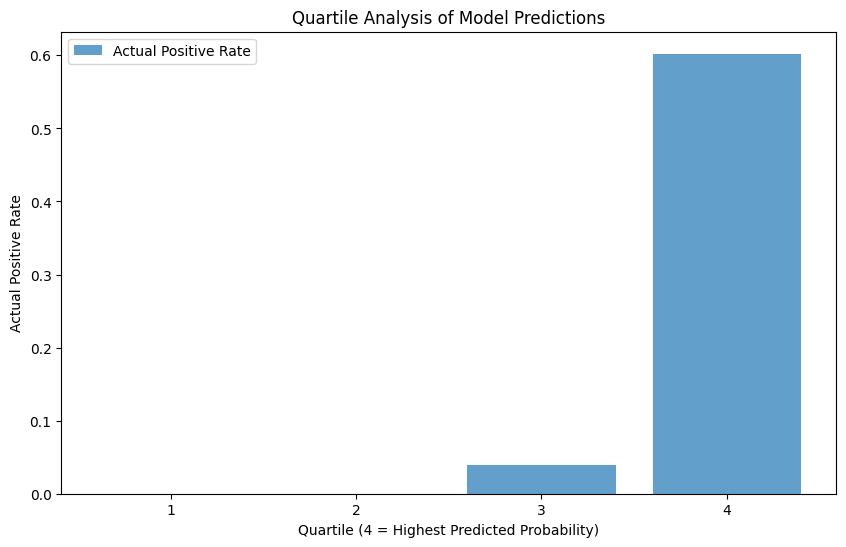

ValueError: All arrays must be of the same length

In [57]:
# Ensure alignment of y_test with X_test after preprocessing
X_test_processed = random_search.best_estimator_.named_steps['preprocessor'].transform(X_test)
if len(X_test_processed) != len(y_test):
    y_test = y_test.iloc[:len(X_test_processed)]  # Align y_test length with processed X_test

# Generate predictions and probabilities
y_pred = random_search.best_estimator_.predict(X_test)
y_score = random_search.best_estimator_.predict_proba(X_test)[:, 1]

# Create a DataFrame to hold actual values and predicted probabilities
results_df = pd.DataFrame({
    'Actual': y_test.reset_index(drop=True),  # Reset index for alignment
    'Predicted_Prob': y_score
})

# Apply pandas.qcut to divide the probabilities into 4 quartiles
results_df['Quartile'] = pd.qcut(results_df['Predicted_Prob'], q=4, labels=False, duplicates='drop') + 1

# Analyze the quartiles
quartile_summary = results_df.groupby('Quartile').agg(
    Count=('Actual', 'size'),
    Avg_Probability=('Predicted_Prob', 'mean'),
    Actual_Rate=('Actual', 'mean')
).sort_index(ascending=False)

# Display quartile analysis
print(quartile_summary)

# Plot quartile performance
plt.figure(figsize=(10, 6))
plt.bar(quartile_summary.index, quartile_summary['Actual_Rate'], alpha=0.7, label='Actual Positive Rate')
plt.xlabel('Quartile (4 = Highest Predicted Probability)')
plt.ylabel('Actual Positive Rate')
plt.title('Quartile Analysis of Model Predictions')
plt.xticks(quartile_summary.index)
plt.legend()
plt.show()

# Optional: Feature Importance Analysis
if hasattr(random_search.best_estimator_.named_steps['classifier'], 'feature_importances_'):
    feature_importance = random_search.best_estimator_.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)
    print(feature_importance_df)


In [58]:
## Look into feature selection and tuning the models once created.  Hyperparameter tuning for the random forest model and stopping rules etc of the model to improve performance and explain.  get_pameters() function?  Iterate and see what works best for random forest.

In [59]:
# Feature selection using SelectKBest with mutual information
selector = SelectKBest(score_func=mutual_info_classif, k=10)  # Select top 10 features
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features.tolist())

Selected Features: ['Tenure', 'WarehouseToHome', 'Complain', 'DaySinceLastOrder', 'CashbackAmount', 'PreferredLoginDevice_Mobile Phone', 'PreferredOrderCat_Laptop & Accessory', 'PreferredOrderCat_Mobile Phone', 'MaritalStatus_Married', 'PreferredPaymentMode_CC']


In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Use RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings sampled
    scoring='roc_auc',
    cv=3,  # Cross-validation folds
    random_state=42,
    n_jobs=-1  # Use all cores
)

# Fit the RandomizedSearchCV
random_search.fit(X_selected, y)

# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best ROC AUC Score:", random_search.best_score_)


Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40}
Best ROC AUC Score: 0.9421879340314808


In [61]:
# Enable out-of-bag (OOB) scoring
rf_model = RandomForestClassifier(
    n_estimators=200,  # Set based on previous tuning
    max_depth=20,  # Optimized value
    min_samples_split=5,
    min_samples_leaf=2,
    oob_score=True,  # Enable OOB scoring
    random_state=42
)

# Fit the model
rf_model.fit(X_selected, y)

# Print OOB score
print("OOB Score:", rf_model.oob_score_)

OOB Score: 0.9062055897678826
